In [3]:
import torch
from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import Compose, SamplePoints, NormalizeScale, KNNGraph, BaseTransform
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, jaccard_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Custom transform to initialize node features
class InitializeNodeFeatures(BaseTransform):
    def __call__(self, data):
        data.x = data.pos  # Set node features as 3D coordinates
        return data

# Compose the transformations
transform = Compose([
    SamplePoints(1024),    # Sample 1024 points
    NormalizeScale(),      # Normalize the 3D coordinates
    KNNGraph(k=16),        # Create a k-NN graph
    InitializeNodeFeatures()  # Initialize `x` from `pos`
])

# Load ModelNet dataset with transformations
dataset = ModelNet(root='data/ModelNet10', name='10', train=True, transform=transform)

# Split dataset into training and validation (80-20 split)
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load test dataset
test_dataset = ModelNet(root='data/ModelNet10', name='10', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [5]:

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 64)  # Input features: (x, y, z)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.fc1 = torch.nn.Linear(256, 128)
        self.fc2 = torch.nn.Linear(128, 10)  # Output layer for 10 classes
    
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [6]:
# Define the training, validation, and testing functions
def train(model, optimizer, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def validate(model, loader):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y).item()
        total_loss += loss
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        correct += (pred == data.y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset), all_preds, all_labels

@torch.no_grad()
def test(model, loader):
    model.eval()
    correct = 0
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset), all_preds, all_labels


In [8]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(25):
    train_loss = train(model, optimizer, train_loader)
    val_loss, val_acc, _, _ = validate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    _, train_acc, _ , _ = validate(model, train_loader)  # Extract accuracy
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Test the model after training
test_acc, test_preds, test_labels = test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 01, Train Loss: 1.8010, Val Loss: 1.3943, Train Acc: 0.5282, Val Acc: 0.5044
Epoch 02, Train Loss: 1.0903, Val Loss: 1.0190, Train Acc: 0.6497, Val Acc: 0.6245
Epoch 03, Train Loss: 0.9167, Val Loss: 0.9238, Train Acc: 0.6754, Val Acc: 0.6558
Epoch 04, Train Loss: 0.8338, Val Loss: 0.8420, Train Acc: 0.7253, Val Acc: 0.7159
Epoch 05, Train Loss: 0.7698, Val Loss: 0.7644, Train Acc: 0.7638, Val Acc: 0.7347
Epoch 06, Train Loss: 0.7280, Val Loss: 0.7623, Train Acc: 0.7594, Val Acc: 0.7434
Epoch 07, Train Loss: 0.6478, Val Loss: 0.6881, Train Acc: 0.7782, Val Acc: 0.7572
Epoch 08, Train Loss: 0.5967, Val Loss: 0.6183, Train Acc: 0.7957, Val Acc: 0.7822
Epoch 09, Train Loss: 0.5706, Val Loss: 0.5754, Train Acc: 0.8208, Val Acc: 0.7972
Epoch 10, Train Loss: 0.5579, Val Loss: 0.6175, Train Acc: 0.8155, Val Acc: 0.7735
Epoch 11, Train Loss: 0.5321, Val Loss: 0.5544, Train Acc: 0.8280, Val Acc: 0.7972
Epoch 12, Train Loss: 0.5033, Val Loss: 0.5490, Train Acc: 0.8127, Val Acc: 0.7960
Epoc

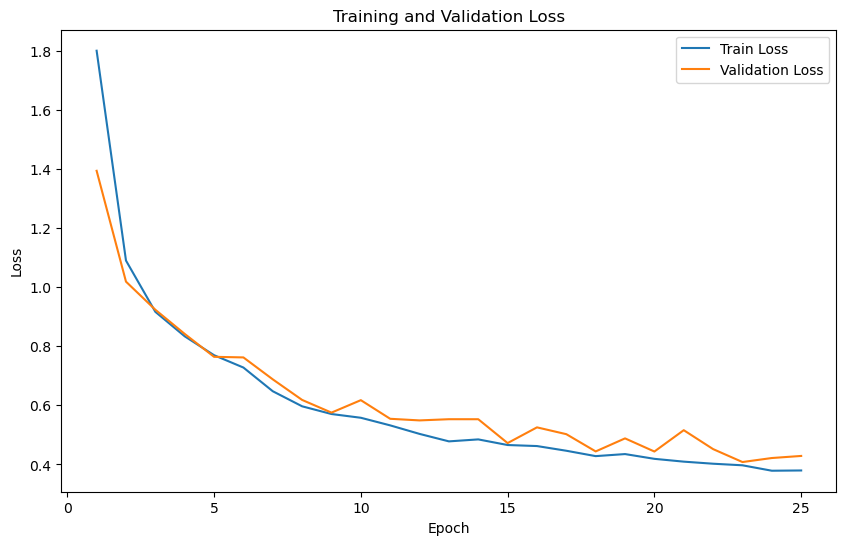

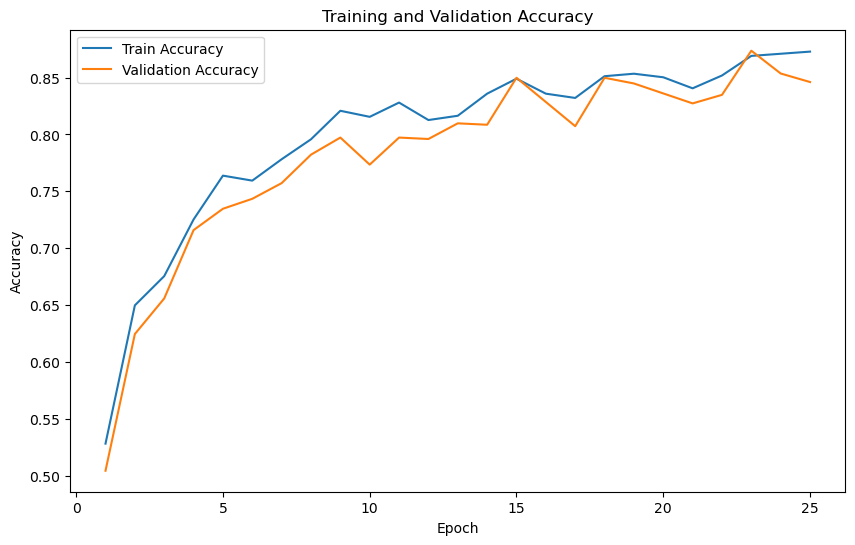

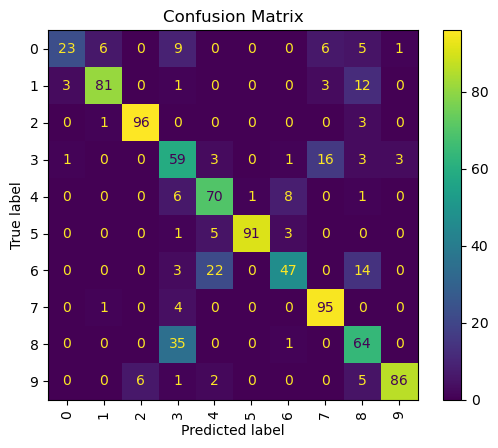

Recall: 0.7637, IoU: 0.6489


In [9]:

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, test_preds, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Calculate and Print Recall and IoU
recall = recall_score(test_labels, test_preds, average="macro")
iou = jaccard_score(test_labels, test_preds, average="macro")
print(f"Recall: {recall:.4f}, IoU: {iou:.4f}")